# 插件：fy_trans 输运方程求解 

## 主要功能

- 汇总 core_transport.model 和 core_sources.source
- 求解输运方程

## 创建 `Tokamak` 实例

输入参数中 `transport_solver` 的内容，用于指定输运方程求解器为`fy_trans`，其中 `equations` 指定了待求解输运方程的主物理量和边界条件类型。

In [1]:
from fytok.Tokamak import Tokamak
import numpy as np

tokamak = Tokamak(
    f"file+iterprofiles://./data/15MA Inductive at burn-ASTRA.xls",
    f"file+geqdsk://./data/g900003.00230_ITER_15MA_eqdsk16HR.txt",
    device="iter",
    shot=900003,
    core_transport={"model": [{"code": {"name": "dummy"}}]},
    core_sources={"source": [{"code": {"name": "dummy"}}]},
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "control_parameters": {
                    "bvp_rms_mask": [0.96],
                    "hyper_diff": 0.0001,
                    "max_nodes": 512,
                    "verbose": 2,
                },
            },
        },
        "primary_coordinate": {"index": (index := 0), "label": r"\bar{rho}_{tor_norm}"},
        "equations": [
            # fmt: off
            {"identifier": "ion/D/density_thermal",    "boundary_condition": [2, 1]},
            {"identifier": "ion/T/density_thermal",    "boundary_condition": [2, 1]},
            {"identifier": "ion/D/temperature",        "boundary_condition": [2, 1]},
            {"identifier": "ion/T/temperature",        "boundary_condition": [2, 1]},
            {"identifier": "electrons/temperature",    "boundary_condition": [2, 1]},
            # fmt: on
        ],
    },
)

2023-11-29 21:16:26,124 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_xml
2023-11-29 21:16:26,558 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-29 21:16:26,635 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk


## 调用求解器 `transport_solver`
给定初始值和边界值，通过多次非线性迭代求解，直到收敛。并可根据需要，自动加密网格。

In [2]:
tokamak.transport_solver.refresh(
    time=0.0,
    initial_value=[1.0e19, 1.0e19, 1000, 1000, 1000],
    boundary_value=[[[0.0], [2.0e19]], [[0.0], [2.0e19]], [[0.0], [1000]], [[0.0], [1000]], [[0.0], [1000]]],
)

2023-11-29 21:16:29,372 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-11-29 21:16:29,764 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-29 21:16:29,796 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.mesh.mesh_rectangular
2023-11-29 21:16:32,038 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy
2023-11-29 21:16:32,094 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_sources.source.dummy
2023-11-29 21:16:32,162 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/modules/Utilities.p

## 中间变量

In [4]:
from spdm.view import View as sp_view

2023-11-25 11:57:55,423 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib


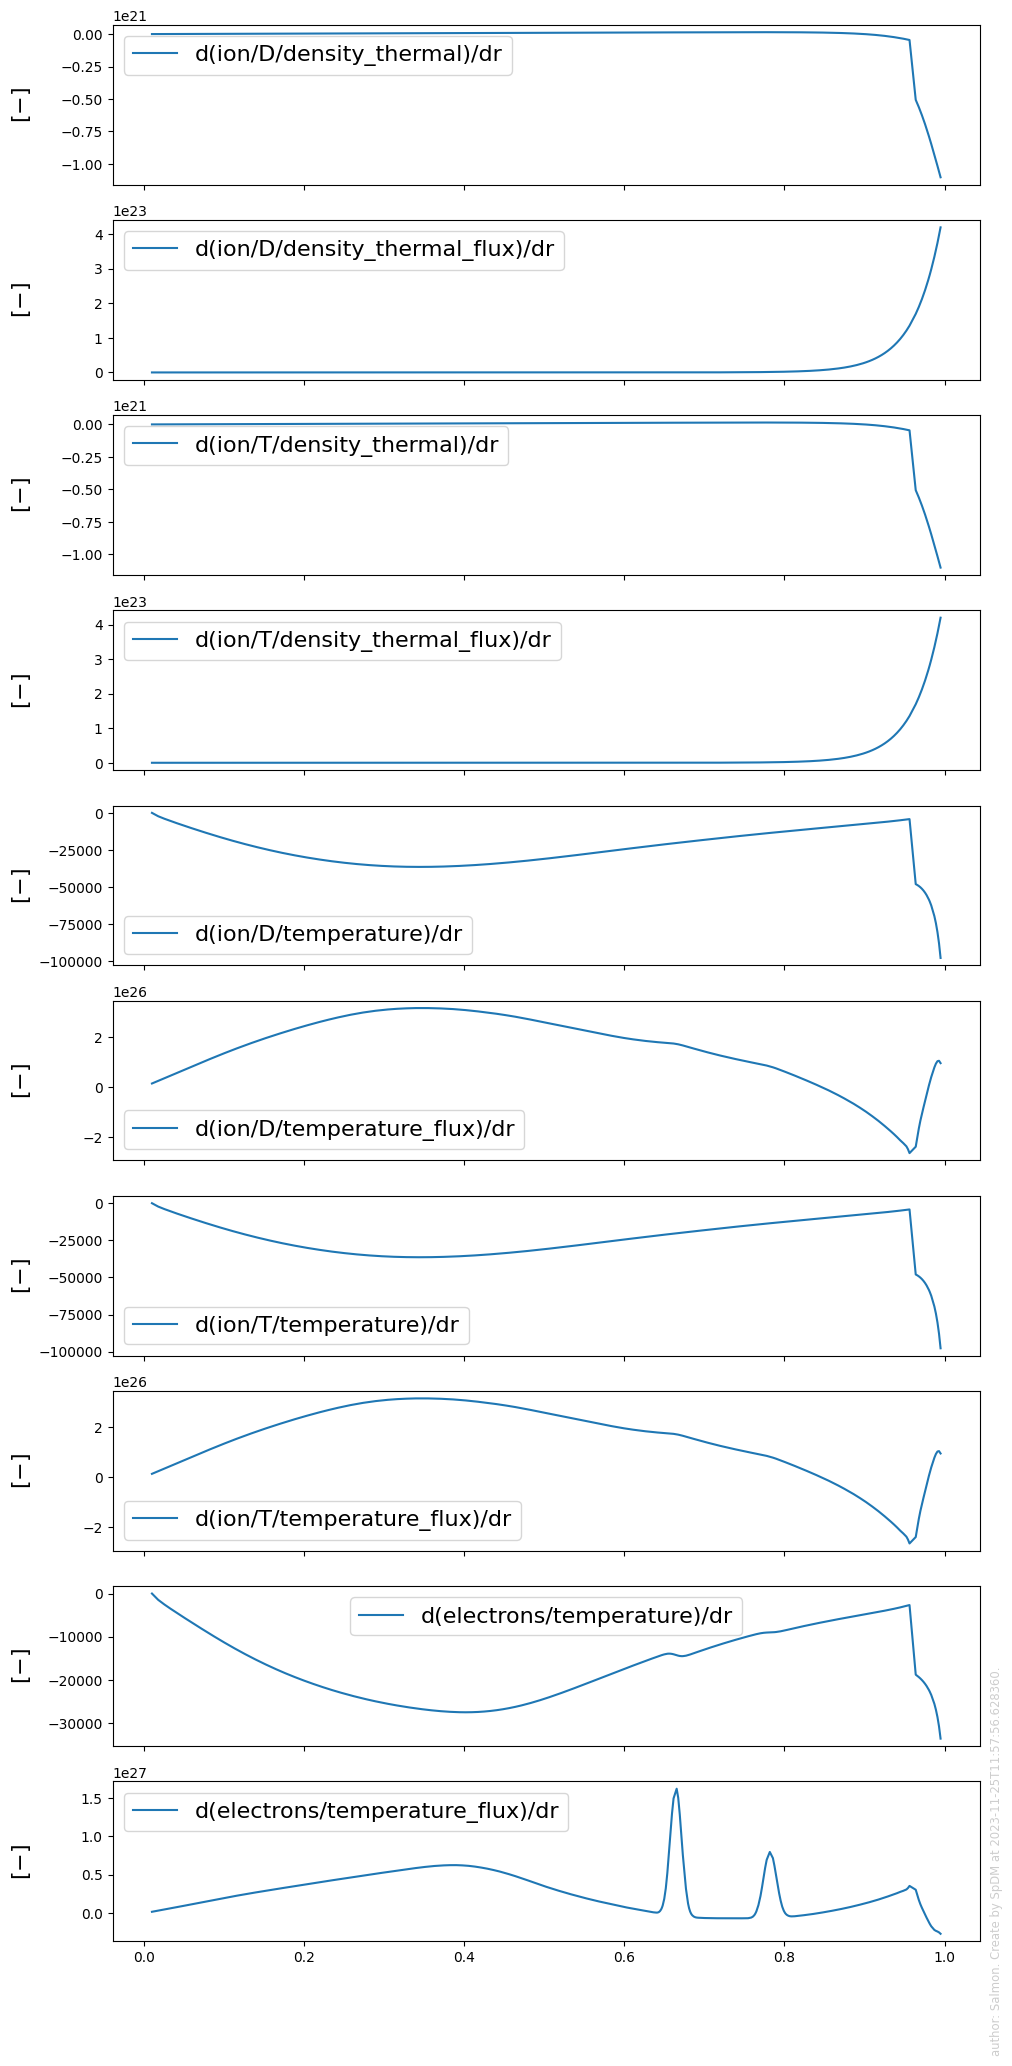

In [5]:
solver_1d = tokamak.transport_solver.time_slice.current
fig = sp_view.plot(
    sum(
        [
            [
                # (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

## 计算结果

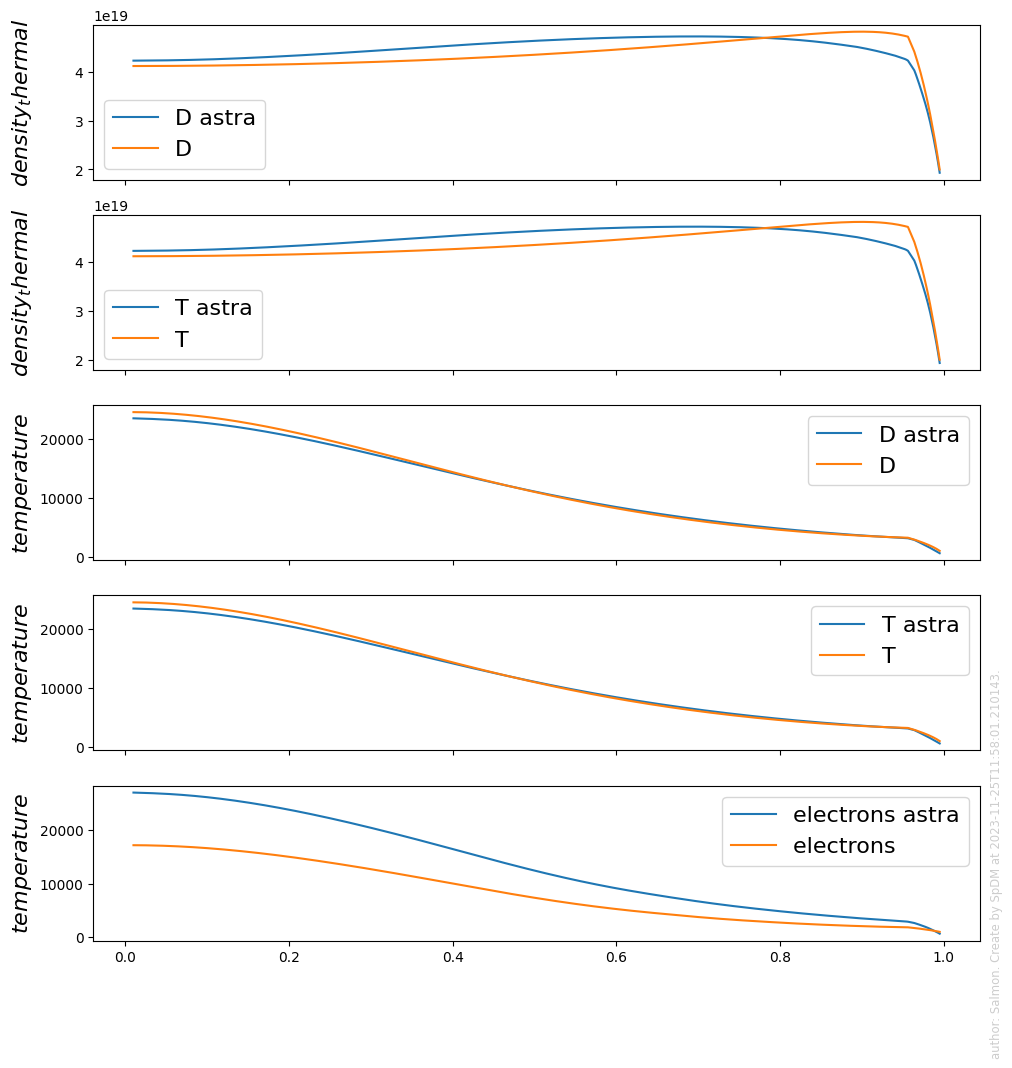

In [6]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot([
    ([
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier.split('/')[-2]} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier.split('/')[-2]} ")
    ],{"y_label": equ.primary_quantity.identifier.split("/")[-1]} ) for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)